In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# PREPROCESSING

Read IBM stock OHLC ( open, high, low, close) and S&P 500 bid/ask data. data into pandas dataframe.

In [231]:
stock=pd.read_csv('삼성전자주가(20220406-20240405).csv')
df=stock.copy()

In [232]:
df["Datetime"] = pd.to_datetime(df["Datetime"]).dt.strftime('%Y-%m-%d %H:%M:%S')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

In [233]:
'''
df.drop('2022-04-06 09:00:00', axis=0, inplace=True)
for i in range(len(df)):
    if i==len(df)-1:
        break
    df.iloc[len(df)-i-1, :]=df.iloc[len(df)-i-1, :]/df.iloc[len(df)-i-2,:]-1
scale_value=df.iloc[0,:]
df.drop('2022-04-06 10:00:00', axis=0, inplace=True)
'''

"\ndf.drop('2022-04-06 09:00:00', axis=0, inplace=True)\nfor i in range(len(df)):\n    if i==len(df)-1:\n        break\n    df.iloc[len(df)-i-1, :]=df.iloc[len(df)-i-1, :]/df.iloc[len(df)-i-2,:]-1\nscale_value=df.iloc[0,:]\ndf.drop('2022-04-06 10:00:00', axis=0, inplace=True)\n"

In [234]:
df

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-04-06 09:00:00,68600.0,68800.0,68600.0,68700.0,68700.0,0
2022-04-06 10:00:00,68600.0,68800.0,68600.0,68700.0,68700.0,1846582
2022-04-06 11:00:00,68700.0,68700.0,68600.0,68600.0,68600.0,901392
2022-04-06 12:00:00,68700.0,68700.0,68500.0,68600.0,68600.0,2053045
2022-04-06 13:00:00,68600.0,68600.0,68500.0,68600.0,68600.0,924688
...,...,...,...,...,...,...
2024-04-05 10:00:00,84700.0,84800.0,83800.0,84000.0,84000.0,3548675
2024-04-05 11:00:00,83900.0,84300.0,83900.0,84200.0,84200.0,1732644
2024-04-05 12:00:00,84300.0,84500.0,84100.0,84400.0,84400.0,1052082


In [235]:
# 데이터 로드 및 선택
features = df[['Open', 'High', 'Low', 'Close', 'Volume']].values

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# 시퀀스 데이터 생성 함수
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length, 3]  # 종가(Close)를 예측값으로 설정
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# 시퀀스 데이터 생성
seq_len = 48  # 시퀀스 길이 설정
X, y = create_sequences(scaled_features, seq_len)
y = y.reshape(-1, 1)  # 모델의 출력 형태에 맞게 y를 조정

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42 , shuffle = False)

# 기존 훈련 데이터를 다시 훈련 및 검증 데이터로 분할
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=False)

In [236]:
# Tensor로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# DataLoader 설정
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=False)

val_data = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(dataset=val_data, batch_size=16, shuffle=False)


# Tensor로 변환
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [255]:
from transformers import PatchTSTConfig, PatchTSTModel

configuration = PatchTSTConfig(prediction_length=1, context_length=seq_len, num_input_channels=5)

model = PatchTSTForPrediction(configuration)

configuration = model.config

In [256]:
import torch.optim as optim

patience = 15  # 검증 손실이 개선되지 않는 에포크 허용 횟수
min_delta = 0.00001  # 개선으로 간주되기 위한 최소 변화량
best_loss = np.inf  # 가장 낮은 검증 손실을 추적dd
last_val_loss = np.inf
patience_counter = 0  # 개선되지 않는 에포크를 세는 카운터

# 손실 함수와 최적화 알고리즘 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 학습 과정
epochs = 100

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()  # 모델을 훈련 모드로 설정
    train_loss = 0.0

    for seqs, labels in train_loader:
        optimizer.zero_grad()  # 그래디언트 초기화
        outputs = model(
            past_values=seqs
        )
        loss = criterion(outputs.prediction_outputs[:,:,3], labels)
        loss.backward()
        optimizer.step()  # 최적화 알고리즘을 통한 파라미터 업데이트
        
        train_loss += loss.item() * seqs.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0

    with torch.no_grad():
        model.eval()
        for seqs, labels in val_loader:
            outputs = model(
                past_values=seqs
            )
            loss = criterion(outputs.prediction_outputs[:,:,3], labels)
            val_loss += loss.item() * seqs.size(0)  # 누적 손실 계산

    # 에포크별 평균 검증 손실 계산
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}')

    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f'Early Stopping Counter {patience_counter} of {patience}')

    last_val_loss = val_loss  # 마지막 검증 손실 업데이트

    if patience_counter >= patience:
        print("Early stopping initiated.")
        print(f"Best Validation Loss: {best_loss:.5f}")
        break

Epoch 1/100, Train Loss: 0.00111, Val Loss: 0.00191
Epoch 2/100, Train Loss: 0.00078, Val Loss: 0.00062
Epoch 3/100, Train Loss: 0.00057, Val Loss: 0.00019
Epoch 4/100, Train Loss: 0.00041, Val Loss: 0.00022
Early Stopping Counter 1 of 15
Epoch 5/100, Train Loss: 0.00026, Val Loss: 0.00030
Early Stopping Counter 2 of 15
Epoch 6/100, Train Loss: 0.00021, Val Loss: 0.00043
Early Stopping Counter 3 of 15
Epoch 7/100, Train Loss: 0.00018, Val Loss: 0.00041
Early Stopping Counter 4 of 15
Epoch 8/100, Train Loss: 0.00017, Val Loss: 0.00033
Early Stopping Counter 5 of 15
Epoch 9/100, Train Loss: 0.00019, Val Loss: 0.00049
Early Stopping Counter 6 of 15
Epoch 10/100, Train Loss: 0.00018, Val Loss: 0.00036
Early Stopping Counter 7 of 15
Epoch 11/100, Train Loss: 0.00018, Val Loss: 0.00038
Early Stopping Counter 8 of 15
Epoch 12/100, Train Loss: 0.00017, Val Loss: 0.00032
Early Stopping Counter 9 of 15
Epoch 13/100, Train Loss: 0.00016, Val Loss: 0.00032
Early Stopping Counter 10 of 15
Epoch 14/

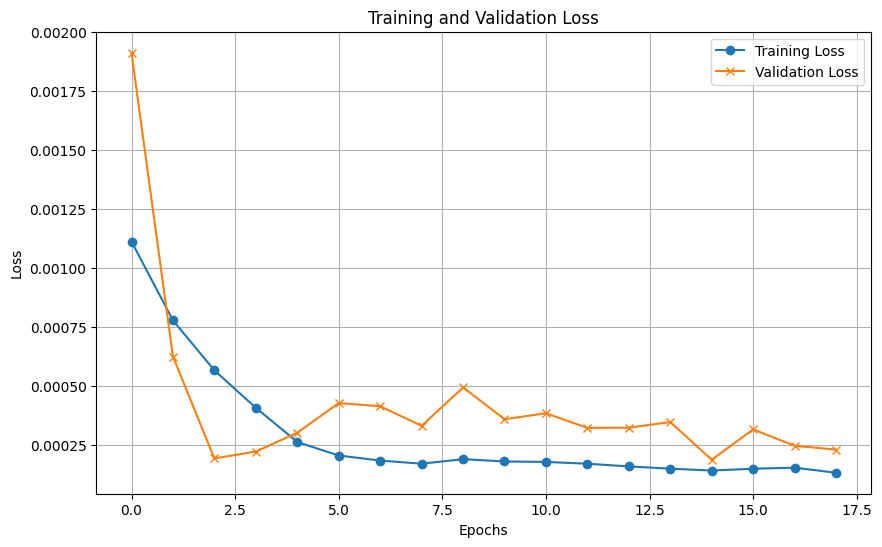

In [257]:
import matplotlib.pyplot as plt

# 위에 제시된 훈련 및 검증 과정 코드 실행 후 실행

# 훈련 손실과 검증 손실을 에포크별로 그래프로 그리기
plt.figure(figsize=(10, 6))  # 그래프 크기 설정
plt.plot(train_losses, label='Training Loss', marker='o')  # 훈련 손실 그래프
plt.plot(val_losses, label='Validation Loss', marker='x')  # 검증 손실 그래프
plt.title('Training and Validation Loss')  # 그래프 제목
plt.xlabel('Epochs')  # x축 라벨
plt.ylabel('Loss')  # y축 라벨
plt.legend()  # 범례 표시
plt.grid(True)  # 그리드 표시
plt.show()  # 그래프 보여주기

In [258]:
# 테스트 데이터셋에 대한 평가 및 결과 출력

model.eval()  # 모델을 평가 모드로 설정
test_losses = []  # 테스트 손실을 저장할 리스트
predictions = []  # 예측값을 저장할 리스트
actuals = []  # 실제값을 저장할 리스트

with torch.no_grad():  # 기울기 계산을 비활성화
    for seqs, labels in DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=16 , shuffle = False):

        outputs = model(seqs)

        # 손실 계산
        loss = criterion(outputs.prediction_outputs[:,:,3], labels)
        test_losses.append(loss.item())

        # 예측값과 실제값 저장
        predictions.extend(outputs.prediction_outputs[:,:,3].view(-1).detach().numpy())
        actuals.extend(labels.view(-1).detach().numpy())

# 평균 테스트 손실 계산 및 출력
average_test_loss = sum(test_losses) / len(test_losses)
print(f'Average Test Loss: {average_test_loss}')

predictions_temp = np.zeros((len(predictions), 5))  # 5는 특성의 총 개수입니다.
predictions_temp[:, 3] = predictions  # 종가 위치에 예측값 할당

actuals_temp = np.zeros((len(actuals), 5))  # 실제 데이터를 위한 동일한 접근 방식
actuals_temp[:, 3] = actuals  # 종가 위치에 실제값 할당


# 예측값과 실제값 출력 (처음 10개 샘플)
predictions_inverse = scaler.inverse_transform(predictions_temp)[:,3]
actuals_inverse = scaler.inverse_transform(actuals_temp)[:,3]


# 역정규화된 예측값과 실제값 출력 (처음 10개 샘플)
print("Predictions vs. Actuals (First 10 Samples, After Inverse Scaling):")
for i in range(10):
    print(f'Prediction: {predictions_inverse[i]:.4f}, Actual: {actuals_inverse[i]:.4f}')

Average Test Loss: 0.0002525966146525829
Predictions vs. Actuals (First 10 Samples, After Inverse Scaling):
Prediction: 74101.0726, Actual: 74000.0000
Prediction: 74000.1413, Actual: 74099.9996
Prediction: 74049.9331, Actual: 74099.9996
Prediction: 74045.4836, Actual: 73900.0003
Prediction: 73901.6228, Actual: 73800.0007
Prediction: 73811.5294, Actual: 74099.9996
Prediction: 73989.6657, Actual: 74000.0000
Prediction: 73928.2736, Actual: 74199.9992
Prediction: 74026.4417, Actual: 73699.9991
Prediction: 73723.2456, Actual: 73699.9991


In [259]:
differences = [abs(pred - actual) for pred, actual in zip(predictions_inverse, actuals_inverse)]

In [260]:
print("최대 : " , max(differences) ,"최소 : " , min(differences) ,"평균: " , sum(differences) / len(differences))

최대 :  2600.876295566559 최소 :  0.7724285125732422 평균:  396.35149420124213


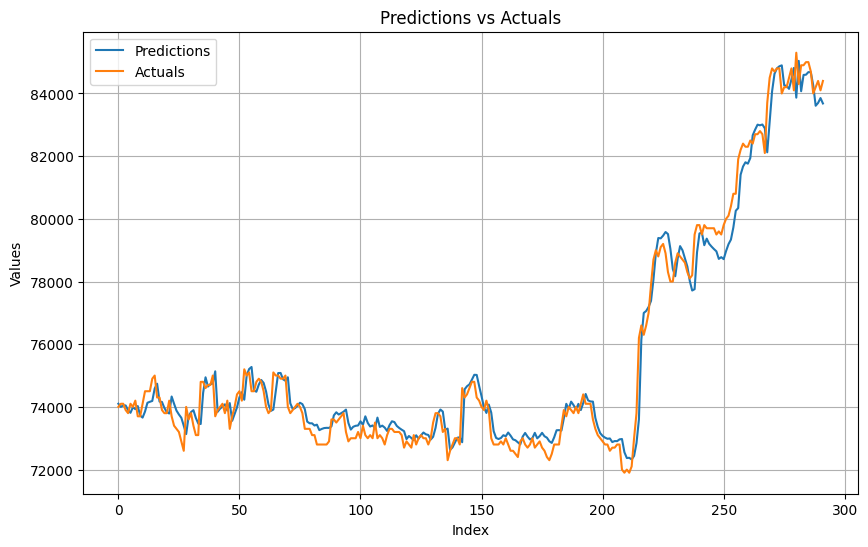

In [261]:
import matplotlib.pyplot as plt

# Plot 생성
plt.figure(figsize=(10, 6))
plt.plot(predictions_inverse, label='Predictions')
plt.plot(actuals_inverse, label='Actuals')
plt.title('Predictions vs Actuals')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()
